# Processing ice thickness data

Adusumilli et al., (2020) provide ice thickness, altimetry-derived height and firn depth as anomalied with respect to the 2010-2018 mean. These values need to be corrected and represented from 2016-2018 as raw thickness change, raw height change, and raw firn column change.

Because ice thickness is calculated using both the height and firn column products, I need to make sure these are corrected into the raw change products first, before calculating ice thickness.

In [83]:
import os
import numpy as np
import rasterio as rio
from rasterio import transform
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.plot import show
from osgeo import gdal 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from fnmatch import fnmatch
from rasterio.transform import Affine
from matplotlib_scalebar.scalebar import ScaleBar
import h5py

Define function for writing to raster

In [84]:
def writeNpToRaster(array, path, name, trans):
    r = rio.open(path + str(name) + '.tif', # save filepath for save
        'w', # 'write' mode
        driver = 'GTiff', # produces a .tif
        height = array.shape[0], # y len
        width = array.shape[1], # x len
        count = 1, # number of bands
        dtype = array.dtype, # get datatype from input array (float)
        crs = 'EPSG:3031', # polar crs
        transform = trans) # transform to projection of another rio DataReader object
    r.write(array,1)
    r.close()

Get directories

In [85]:
# altimetry height anomalies
heightAnomDir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_anoms')
heightAnomFiles = [file for file in heightAnomDir if fnmatch(file, '*.tif')]

# firn anomalies
firnAnomDir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_anoms')
firnAnomFiles = [file for file in firnAnomDir if fnmatch(file, '*.tif')]

This is a tricky bit, my files are not sorted properly. So I need to order them according to their chronological month order, and **then** I can loop through and calculate the difference.
If I set up an ordered lookup list for the filenames, then I can output them in order.

In [86]:
years = ['2016', '2017', '2018']
seasons = ['DJF', 'MAM', 'JJA', 'SON']
ys = []
for year in years:
    for season in seasons:
        ys.append(year+season)
print(ys)

['2016DJF', '2016MAM', '2016JJA', '2016SON', '2017DJF', '2017MAM', '2017JJA', '2017SON', '2018DJF', '2018MAM', '2018JJA', '2018SON']


So for value index 0, the change between that and zero is relatively large given the smaller changes afterwards. It doesn't make change to subtract zero from index zero because that isn't the raw height change. I need to track the changes **from** index 1 afterwards.

So below I loop to compute the differences starting at index 1, not zero.

i.e.

In [87]:
for i in range(1,12):
    print(f'Calculation {i}:')
    print(f'\t{ys[i]}-{ys[i-1]}')

Calculation 1:
	2016MAM-2016DJF
Calculation 2:
	2016JJA-2016MAM
Calculation 3:
	2016SON-2016JJA
Calculation 4:
	2017DJF-2016SON
Calculation 5:
	2017MAM-2017DJF
Calculation 6:
	2017JJA-2017MAM
Calculation 7:
	2017SON-2017JJA
Calculation 8:
	2018DJF-2017SON
Calculation 9:
	2018MAM-2018DJF
Calculation 10:
	2018JJA-2018MAM
Calculation 11:
	2018SON-2018JJA


In [88]:
# dh height
dh_anom_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_anoms/'
dhrawPath = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/'

transform = Affine(10000.00, 0.00,-2040000.00, 0.00,-10000.00, 820000.00)

for i in range(1, 12): # starting at index 1 NOT ZERO
    
    print(f'\tDoing file: \n{ys[i]}-{ys[i-1]}') # we're now working to an ordered index
    
    with rio.open(dh_anom_path + ys[i] + '_alt_corr_cropped.tif') as src1, rio.open(dh_anom_path + ys[i-1] + '_alt_corr_cropped.tif') as src0:
        
        data = src1.read(1, masked = True)
        
        data = np.delete(data,32,1) # remove excess column
        data = np.delete(data,range(35,48),0) # remove lower rows
        
        data0 = src0.read(1, masked = True)
        
        data0 = np.delete(data0,32,1) # remove excess column
        data0 = np.delete(data0,range(35,48),0) # remove lower rows
        
        change = data-data0 # calculate raw height change from anomaly differences
        
        name = ys[i]
        print(f'Writing file {name}')
        
        writeNpToRaster(change, dhrawPath, name, transform)

	Doing file: 
2016MAM-2016DJF
Writing file 2016MAM
	Doing file: 
2016JJA-2016MAM
Writing file 2016JJA
	Doing file: 
2016SON-2016JJA
Writing file 2016SON
	Doing file: 
2017DJF-2016SON
Writing file 2017DJF
	Doing file: 
2017MAM-2017DJF
Writing file 2017MAM
	Doing file: 
2017JJA-2017MAM
Writing file 2017JJA
	Doing file: 
2017SON-2017JJA
Writing file 2017SON
	Doing file: 
2018DJF-2017SON
Writing file 2018DJF
	Doing file: 
2018MAM-2018DJF
Writing file 2018MAM
	Doing file: 
2018JJA-2018MAM
Writing file 2018JJA
	Doing file: 
2018SON-2018JJA
Writing file 2018SON


Now let's check the change between raw and corrected data

In [89]:
anomdjf = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_anoms/2016DJF_alt_corr_cropped.tif')
anommam = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_anoms/2016MAM_alt_corr_cropped.tif')
diff = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/2016MAM.tif')

print(anomdjf.read(1)[17,30])
print(anommam.read(1)[17,30])
print(diff.read(1)[17,30])

-0.013129493864435725
-0.01276932847572136
0.00036016538871436535


Now repeat for firn difference

In [90]:
# dh height
dair_anom_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_anoms/'
dair_rawPath = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/'

transform = Affine(10000.00, 0.00,-2040000.00, 0.00,-10000.00, 820000.00)

for i in range(1, 12): # starting at index 1 NOT ZERO
    
    print(f'\tDoing file: \n{ys[i]}-{ys[i-1]}') # we're now working to an ordered index
    
    with rio.open(dair_anom_path + ys[i] + '_firn_corr_cropped.tif') as src1, rio.open(dair_anom_path + ys[i-1] + '_firn_corr_cropped.tif') as src0:
        
        data = src1.read(1, masked = True)
        
        data = np.delete(data,32,1) # remove excess column
        data = np.delete(data,range(35,48),0) # remove lower rows
        
        data0 = src0.read(1, masked = True)
        
        data0 = np.delete(data0,32,1) # remove excess column
        data0 = np.delete(data0,range(35,48),0) # remove lower rows
        
        change = data-data0 # calculate raw height change from anomaly differences
        
        name = ys[i]
        print(f'Writing file {name}')
        
        writeNpToRaster(change, dair_rawPath, name, transform)

	Doing file: 
2016MAM-2016DJF
Writing file 2016MAM
	Doing file: 
2016JJA-2016MAM
Writing file 2016JJA
	Doing file: 
2016SON-2016JJA
Writing file 2016SON
	Doing file: 
2017DJF-2016SON
Writing file 2017DJF
	Doing file: 
2017MAM-2017DJF
Writing file 2017MAM
	Doing file: 
2017JJA-2017MAM
Writing file 2017JJA
	Doing file: 
2017SON-2017JJA
Writing file 2017SON
	Doing file: 
2018DJF-2017SON
Writing file 2018DJF
	Doing file: 
2018MAM-2018DJF
Writing file 2018MAM
	Doing file: 
2018JJA-2018MAM
Writing file 2018JJA
	Doing file: 
2018SON-2018JJA
Writing file 2018SON


In [91]:
anomdjf = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_anoms/2016DJF_firn_corr_cropped.tif')
anommam = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_anoms/2016MAM_firn_corr_cropped.tif')
diff = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/2016MAM.tif')

print(anomdjf.read(1)[17,30])
print(anommam.read(1)[17,30])
print('Difference: ' + str(diff.read(1)[17,30]))

0.0007076673674859248
0.0009803167289191657
Difference: 0.0002726493614332409


So now, working to the **same** lookup file list, I need to calculate the height change.

In [92]:
# get height change
dh_dir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw')
dh_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/'
dh_files = [file for file in dh_dir if fnmatch(file, '*.tif')]

air_dir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw')
air_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/'
air_files = [file for file in air_dir if fnmatch(file, '*.tif')]

output_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/thickness/thickness_raw/'

rho_ow = 1028 # density of ocean water
rho_ice = 917 # density of ice

for i in range(1,12): # 3 years' worth of seasons starting at index 1 NOT ZERO
    
    name = ys[i] # get filename
    
    print(f'Doing file {ys[i]}')
    
    dh = dh_path + ys[i] + '.tif' # get raw height change INDEXED
    
    air = air_path + ys[i] + '.tif' # get raw firn change INDEXED
    
    with rio.open(dh) as dh_src, rio.open(air) as air_src:
        
        dh_data = dh_src.read(1)
        
        air_data = air_src.read(1)
        
    thickness = (dh_data - air_data)*(1+rho_ice/(rho_ow - rho_ice)) # calculate ice thickness change
    
    trans = Affine(10000.0, 0.0, -2040000.0,0.0, -10000.0, 820000.0)
    
    writeNpToRaster(thickness, output_path, name, trans)    

Doing file 2016MAM
Doing file 2016JJA
Doing file 2016SON
Doing file 2017DJF
Doing file 2017MAM
Doing file 2017JJA
Doing file 2017SON
Doing file 2018DJF
Doing file 2018MAM
Doing file 2018JJA
Doing file 2018SON


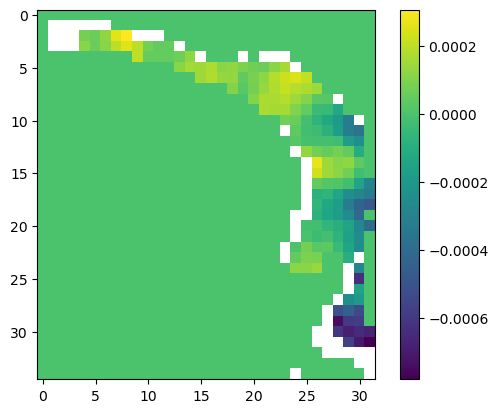

In [93]:
# now for the moment of truth
with rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/2017JJA.tif') as thickness:
    th = thickness.read(1, masked = True)
    fig,ax =plt.subplots()
    plt.imshow(th, cmap = 'viridis')
    hid = ax.imshow(th, cmap = 'viridis')
    plt.colorbar(hid,ax=ax)